In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import simps

In [2]:
def gaussian_density(x, mu, var):
    return 1 / np.sqrt(2 * np.pi * var) * np.exp(-(x - mu)**2 / (2 * var))

def gaussian_density_log(x, mu, var):
    return -np.log(2 * np.pi * var) / 2 - (x - mu)**2 / (2 * var)

In [3]:
rng = np.random.default_rng(2020)
N = 20 # number of samples
theta = 2 # parameter to infer
samples = np.where(rng.random(N) > 0.5, 
                  rng.normal(theta, 1, N), 
                  rng.normal(0, np.sqrt(10), N))

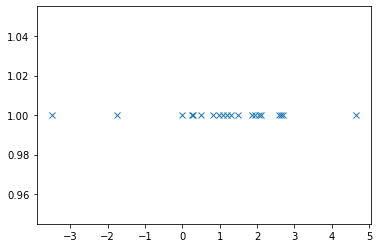

In [4]:
plt.plot(samples, np.ones_like(samples), 'x')

In [5]:
def exact_posterior(theta, x):
    post_density_log = gaussian_density_log(theta, 0, 100)
    for x_i in x:
        post_density_log += np.log(0.5 * gaussian_density(x_i, theta, 1) + 
                                  0.5 * gaussian_density(x_i, 0, 10))
    post_density_log -= np.max(post_density_log)
    post_density = np.exp(post_density_log)
    return post_density

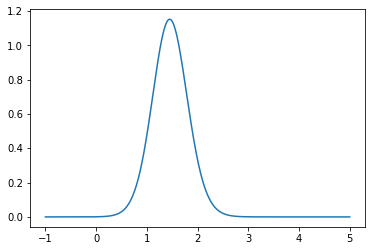

In [6]:
theta = np.linspace(-1, 5, int(10**6))
post_density_true = exact_posterior(theta, samples) # this posterior is unnormalized
normalizer = simps(post_density_true, theta)
post_density_true /= normalizer
plt.plot(theta, post_density_true)

### ADF

In [7]:
def moment_matching(x_i, mu, v):
    Z_i = 0.5 * gaussian_density(x_i, mu, v+1) + 0.5 * gaussian_density(x_i, 0, 10)
    r_i = 0.5 * gaussian_density(x_i, mu, v+1) / Z_i
    mu_new = mu + v * r_i * (x_i - mu) / (v + 1)
    v_new = v - r_i * v**2 / (v+1) + r_i * (1 - r_i) * v**2 * (x_i - mu) ** 2 / (v + 1)**2
    return Z_i, r_i, mu_new, v_new

def adf_posterior(x):
    # initialize m v and s
    mu = 0
    v = 100
    log_s = 0    
    idx_list = np.arange(len(x))
    rng.shuffle(idx_list)
#     print(idx_list)
    for i in idx_list:
        x_i = x[i]
        # update (m, v, s)
        Z_i, r_i, mu_new, v_new = moment_matching(x_i, mu, v)
        log_s += np.log(Z_i)
        mu = mu_new
        v = v_new
    return mu, v, log_s

Text(0, 0.5, '$p(\\theta \\vert D)$')

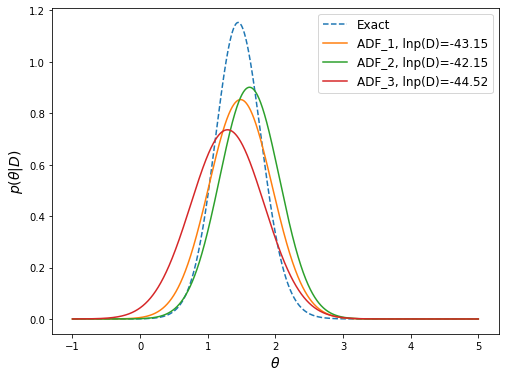

In [8]:
plt.figure(figsize=(8, 6))

plt.plot(theta, post_density_true, '--', label='Exact')

mu, v, lns = adf_posterior(samples)
plt.plot(theta, gaussian_density(theta, mu, v), label='ADF_1, lnp(D)=%.2f' % lns)

mu, v, lns = adf_posterior(samples)
plt.plot(theta, gaussian_density(theta, mu, v), label='ADF_2, lnp(D)=%.2f' % lns)

mu, v, lns = adf_posterior(samples)
plt.plot(theta, gaussian_density(theta, mu, v), label='ADF_3, lnp(D)=%.2f' % lns)

plt.legend(fontsize=12)
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel(r'$p(\theta \vert D)$', fontsize=14)

### EP

In [9]:
def ep_posterior(x):
    # initialize the prior
    mu_0 = 0
    v_0 = 100
    s_0 = 1 / np.sqrt(2 * np.pi * v_0)
    
    # initialize data term
    mu_arr = np.zeros(N)
    v_arr = np.zeros(N) + np.inf
    s_arr = np.ones(N)
    
    mu = mu_0
    v = v_0
    
    for t in range(100):
        for i in range(N):
            xi = x[i]
            mu_i = mu_arr[i]
            v_i = v_arr[i]
            # remove i, calculate cavity distribution
            v_c_inv = 1/v - 1/v_i
            if v_c_inv <= 0:
#                 print('Zero!')
                continue
            v_c = 1/v_c_inv
            mu_c = mu + v_c * 1/v_i * (mu - mu_i)
        
            # compute new q, same as ADF
            Zi, ri, mu_new, v_new = moment_matching(xi, mu_c, v_c)

            # update t_i
            v_i_inv = 1/v_new - v_c_inv
            if v_i_inv <= 0:
#                 print('Zero!')
                continue
            v_i = 1/v_i_inv
            mu_i = mu_c + (v_i + v_c) * 1/v_c * (mu_new - mu_c)
            s_i = Zi / np.sqrt(2 * np.pi * v_i) / gaussian_density(mu_i, mu_c, (v_i + v_c))
            mu_arr[i] = mu_i
            v_arr[i] = v_i
            s_arr[i] = s_i
            
            # update posterior
            mu = mu_new
            v = v_new
            
    return mu_arr, v_arr, s_arr, mu, v

In [10]:
mu_arr, v_arr, s_arr, mu, v = ep_posterior(samples)
print(mu, v)

1.4381746621006655 0.11419228127681551


Text(0, 0.5, '$p(\\theta \\vert D)$')

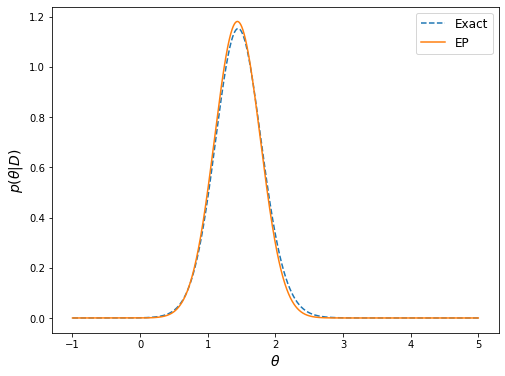

In [11]:
plt.figure(figsize=(8, 6))

plt.plot(theta, post_density_true, '--', label='Exact')

post_density_ep = gaussian_density(theta, mu, v)
plt.plot(theta, post_density_ep, label='EP')

plt.legend(fontsize=12)
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel(r'$p(\theta \vert D)$', fontsize=14)